In [21]:
import torch
import torch.nn as nn

In [22]:
class DiffusionForwardProcess:
    
    r"""
    
    Forward Process class as described in the 
    paper "Denoising Diffusion Probabilistic Models"
    
    """
    
    def __init__(self, 
                 num_time_steps = 1000, 
                 beta_start = 1e-4, 
                 beta_end = 0.02
                ):
        
        # Precomputing beta, alpha, and alpha_bar for all t's.
        self.betas = torch.linspace(beta_start, beta_end, num_time_steps)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alpha_bars = torch.sqrt(self.alpha_bars)
        self.sqrt_one_minus_alpha_bars = torch.sqrt(1 - self.alpha_bars)
        
    def add_noise(self, original, noise, t):
        
        r""" Adds noise to a batch of original images at time-step t.
        
        :param original: Input Image Tensor
        :param noise: Random Noise Tensor sampled from Normal Dist N(0, 1)
        :param t: timestep of the forward process of shape -> (B, )
        
        Note: time-step t may differ for each image inside the batch.
        
        """
        
        sqrt_alpha_bar_t = self.sqrt_alpha_bars.to(original.device)[t]
        sqrt_one_minus_alpha_bar_t = self.sqrt_one_minus_alpha_bars.to(original.device)[t]
        
        # Broadcast to multiply with the original image.
        sqrt_alpha_bar_t = sqrt_alpha_bar_t[:, None, None, None]
        sqrt_one_minus_alpha_bar_t = sqrt_one_minus_alpha_bar_t[:, None, None, None]
        
        # Return
        return (sqrt_alpha_bar_t * original) \
                           + \
               (sqrt_one_minus_alpha_bar_t * noise)
# Test

In [23]:
original = torch.randn(4, 1, 28, 28)
noise = torch.randn(4, 1, 28, 28)
t_steps = torch.randint(0, 1000, (4,)) 

# Forward Process
dfp = DiffusionForwardProcess()
out = dfp.add_noise(original, noise, t_steps)
out.shape

torch.Size([4, 1, 28, 28])

In [24]:

class DiffusionReverseProcess:
    
    r"""
    
    Reverse Process class as described in the 
    paper "Denoising Diffusion Probabilistic Models"
    
    """
    
    def __init__(self, 
                 num_time_steps = 1000, 
                 beta_start = 1e-4, 
                 beta_end = 0.02
                ):
        
        # Precomputing beta, alpha, and alpha_bar for all t's.
        self.b = torch.linspace(beta_start, beta_end, num_time_steps) # b -> beta
        self.a = 1 - self.b # a -> alpha
        self.a_bar = torch.cumprod(self.a, dim=0) # a_bar = alpha_bar
        
    def sample_prev_timestep(self, xt, noise_pred, t):
        
        r""" Sample x_(t-1) given x_t and noise predicted
             by model.
             
             :param xt: Image tensor at timestep t of shape -> B x C x H x W
             :param noise_pred: Noise Predicted by model of shape -> B x C x H x W
             :param t: Current time step

        """
        
        # Original Image Prediction at timestep t
        x0 = xt - (torch.sqrt(1 - self.a_bar.to(xt.device)[t]) * noise_pred)
        x0 = x0/torch.sqrt(self.a_bar.to(xt.device)[t])
        x0 = torch.clamp(x0, -1., 1.) 
        
        # mean of x_(t-1)
        mean = (xt - ((1 - self.a.to(xt.device)[t]) * noise_pred)/(torch.sqrt(1 - self.a_bar.to(xt.device)[t])))
        mean = mean/(torch.sqrt(self.a.to(xt.device)[t]))
        
        # only return mean
        if t == 0:
            return mean, x0
        
        else:
            variance =  (1 - self.a_bar.to(xt.device)[t-1])/(1 - self.a_bar.to(xt.device)[t])
            variance = variance * self.b.to(xt.device)[t]
            sigma = variance**0.5
            z = torch.randn(xt.shape).to(xt.device)
            
            return mean + sigma * z, x0

In [25]:
original = torch.randn(1, 1, 28, 28)
noise_pred = torch.randn(1, 1, 28, 28)
t = torch.randint(0, 1000, (1,)) 

# Forward Process
drp = DiffusionReverseProcess()
out, x0 = drp.sample_prev_timestep(original, noise_pred, t)
out.shape

torch.Size([1, 1, 28, 28])

In [26]:
def get_time_embedding(
    time_steps: torch.Tensor,
    t_emb_dim: int
) -> torch.Tensor:
    
    """ 
    Transform a scalar time-step into a vector representation of size t_emb_dim.
    
    :param time_steps: 1D tensor of size -> (Batch,)
    :param t_emb_dim: Embedding Dimension -> for ex: 128 (scalar value)
    
    :return tensor of size -> (B, t_emb_dim)
    """
    
    assert t_emb_dim%2 == 0, "time embedding must be divisible by 2."
    
    factor = 2 * torch.arange(start = 0, 
                              end = t_emb_dim//2, 
                              dtype=torch.float32, 
                              device=time_steps.device
                             ) / (t_emb_dim)
    
    factor = 10000**factor

    t_emb = time_steps[:,None] # B -> (B, 1) 
    t_emb = t_emb/factor # (B, 1) -> (B, t_emb_dim//2)
    t_emb = torch.cat([torch.sin(t_emb), torch.cos(t_emb)], dim=1) # (B , t_emb_dim)
    
    return t_emb

In [27]:
class NormActConv(nn.Module):
    """
    Perform GroupNorm, Activation, and Convolution operations.
    """
    def __init__(self, 
                 in_channels:int, 
                 out_channels:int, 
                 num_groups:int = 8, 
                 kernel_size: int = 3, 
                 norm:bool = True,
                 act:bool = True
                ):
        super(NormActConv, self).__init__()
        
        # GroupNorm
        self.g_norm = nn.GroupNorm(
            num_groups,
            in_channels
        ) if norm is True else nn.Identity()
        
        # Activation
        self.act = nn.SiLU() if act is True else nn.Identity()
        
        # Convolution
        self.conv = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size, 
            padding=(kernel_size - 1)//2
        )
        
    def forward(self, x):
        x = self.g_norm(x)
        x = self.act(x)
        x = self.conv(x)
        return x
    
#-----------------------------------------------------------------

class TimeEmbedding(nn.Module):
    """
    Maps the Time Embedding to the Required output Dimension.
    """
    def __init__(self, 
                 n_out:int, # Output Dimension
                 t_emb_dim:int = 128 # Time Embedding Dimension
                ):
        super(TimeEmbedding, self).__init__()
        
        # Time Embedding Block
        self.te_block = nn.Sequential(
            nn.SiLU(), 
            nn.Linear(t_emb_dim, n_out)
        )
        
    def forward(self, x):
        return self.te_block(x)
    
#---------------------------------------------------------------

class SelfAttentionBlock(nn.Module):
    """
    Perform GroupNorm and Multiheaded Self Attention operation.    
    """
    def __init__(self, 
                 num_channels:int,
                 num_groups:int = 8, 
                 num_heads:int = 4,
                 norm:bool = True
                ):
        super(SelfAttentionBlock, self).__init__()
        
        # GroupNorm
        self.g_norm = nn.GroupNorm(
            num_groups,
            num_channels
        ) if norm is True else nn.Identity()
        
        # Self-Attention
        self.attn = nn.MultiheadAttention(
            num_channels,
            num_heads, 
            batch_first=True
        )
        
    def forward(self, x):
        batch_size, channels, h, w = x.shape
        x = x.reshape(batch_size, channels, h*w)
        x = self.g_norm(x)
        x = x.transpose(1, 2)
        x, _ = self.attn(x, x, x)
        x = x.transpose(1, 2).reshape(batch_size, channels, h, w)
        return x
    
#----------------------------------------------------------------

class Downsample(nn.Module):
    """
    Perform Downsampling by the factor of k across Height and Width.
    """
    def __init__(self, 
                 in_channels:int, 
                 out_channels:int, 
                 k:int = 2, # Downsampling factor
                 use_conv:bool = True, # If Downsampling using conv-block
                 use_mpool:bool = True # If Downsampling using max-pool
                ):
        super(Downsample, self).__init__()
        
        self.use_conv = use_conv
        self.use_mpool = use_mpool
        
        # Downsampling using Convolution
        self.cv = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=1), 
            nn.Conv2d(
                in_channels, 
                out_channels//2 if use_mpool else out_channels, 
                kernel_size=4, 
                stride=k, 
                padding=1
            )
        ) if use_conv else nn.Identity()
        
        # Downsampling using Maxpool
        self.mpool = nn.Sequential(
            nn.MaxPool2d(k, k), 
            nn.Conv2d(
                in_channels, 
                out_channels//2 if use_conv else out_channels, 
                kernel_size=1, 
                stride=1, 
                padding=0
            )
        ) if use_mpool else nn.Identity()
        
    def forward(self, x):
        
        if not self.use_conv:
            return self.mpool(x)
        
        if not self.use_mpool:
            return self.cv(x)
            
        return torch.cat([self.cv(x), self.mpool(x)], dim=1)
    
#-----------------------------------------------------------------------

class Upsample(nn.Module):
    """
    Perform Upsampling by the factor of k across Height and Width
    """
    def __init__(self, 
                 in_channels:int, 
                 out_channels:int, 
                 k:int = 2, # Upsampling factor
                 use_conv:bool = True, # Upsampling using conv-block
                 use_upsample:bool = True # Upsampling using nn.upsample
                ):
        super(Upsample, self).__init__()
        
        self.use_conv = use_conv
        self.use_upsample = use_upsample
        
        # Upsampling using conv
        self.cv = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels//2 if use_upsample else out_channels, 
                kernel_size=4, 
                stride=k, 
                padding=1
            ),
            nn.Conv2d(
                out_channels//2 if use_upsample else out_channels, 
                out_channels//2 if use_upsample else out_channels, 
                kernel_size = 1, 
                stride=1, 
                padding=0
            )
        ) if use_conv else nn.Identity()
        
        # Upsamling using nn.Upsample
        self.up = nn.Sequential(
            nn.Upsample(
                scale_factor=k, 
                mode = 'bilinear', 
                align_corners=False
            ),
            nn.Conv2d(
                in_channels,
                out_channels//2 if use_conv else out_channels, 
                kernel_size=1, 
                stride=1, 
                padding=0
            )
        ) if use_upsample else nn.Identity()
        
    def forward(self, x):
        
        if not self.use_conv:
            return self.up(x)
        
        if not self.use_upsample:
            return self.cv(x)
        
        return torch.cat([self.cv(x), self.up(x)], dim=1)


In [28]:
layer = Upsample(16, 32, 2, True, True)
x = torch.randn(4, 16, 32, 32)
layer(x).shape

torch.Size([4, 32, 64, 64])

In [29]:
class DownC(nn.Module):
    """
    Perform Down-convolution on the input using following approach.
    1. Conv + TimeEmbedding
    2. Conv
    3. Skip-connection from input x.
    4. Self-Attention
    5. Skip-Connection from 3.
    6. Downsampling
    """
    def __init__(self, 
                 in_channels:int, 
                 out_channels:int, 
                 t_emb_dim:int = 128, # Time Embedding Dimension
                 num_layers:int=2,
                 down_sample:bool = True # True for Downsampling
                ):
        super(DownC, self).__init__()
        
        self.num_layers = num_layers
        
        self.conv1 = nn.ModuleList([
            NormActConv(in_channels if i==0 else out_channels, 
                        out_channels
                       ) for i in range(num_layers)
        ])
        
        self.conv2 = nn.ModuleList([
            NormActConv(out_channels, 
                        out_channels
                       ) for _ in range(num_layers)
        ])
        
        self.te_block = nn.ModuleList([
            TimeEmbedding(out_channels, t_emb_dim) for _ in range(num_layers)
        ])
        
        self.attn_block = nn.ModuleList([
            SelfAttentionBlock(out_channels) for _ in range(num_layers)
        ])
        
        self.down_block =Downsample(out_channels, out_channels) if down_sample else nn.Identity()
        
        self.res_block = nn.ModuleList([
            nn.Conv2d(
                in_channels if i==0 else out_channels, 
                out_channels, 
                kernel_size=1
            ) for i in range(num_layers)
        ])
        
    def forward(self, x, t_emb):
        
        out = x
        
        for i in range(self.num_layers):
            resnet_input = out
            
            # Resnet Block
            out = self.conv1[i](out)
            out = out + self.te_block[i](t_emb)[:, :, None, None]
            out = self.conv2[i](out)
            out = out + self.res_block[i](resnet_input)

            # Self Attention
            out_attn = self.attn_block[i](out)
            out = out + out_attn

        # Downsampling
        out = self.down_block(out)
        
        return out

In [30]:
class MidC(nn.Module):
    """
    Refine the features obtained from the DownC block.
    It refines the features using following operations:
    
    1. Resnet Block with Time Embedding
    2. A Series of Self-Attention + Resnet Block with Time-Embedding 
    """
    def __init__(self, 
                 in_channels:int, 
                 out_channels:int,
                 t_emb_dim:int = 128,
                 num_layers:int = 2
                ):
        super(MidC, self).__init__()
        
        self.num_layers = num_layers
        
        self.conv1 = nn.ModuleList([
            NormActConv(in_channels if i==0 else out_channels, 
                        out_channels
                       ) for i in range(num_layers + 1)
        ])
        
        self.conv2 = nn.ModuleList([
            NormActConv(out_channels, 
                        out_channels
                       ) for _ in range(num_layers + 1)
        ])
        
        self.te_block = nn.ModuleList([
            TimeEmbedding(out_channels, t_emb_dim) for _ in range(num_layers + 1)
        ])
        
        self.attn_block = nn.ModuleList([
            SelfAttentionBlock(out_channels) for _ in range(num_layers)
        ])
        
        self.res_block = nn.ModuleList([
            nn.Conv2d(
                in_channels if i==0 else out_channels, 
                out_channels, 
                kernel_size=1
            ) for i in range(num_layers + 1)
        ])
        
    def forward(self, x, t_emb):
        out = x
        
        # First-Resnet Block
        resnet_input = out
        out = self.conv1[0](out)
        out = out + self.te_block[0](t_emb)[:, :, None, None]
        out = self.conv2[0](out)
        out = out + self.res_block[0](resnet_input)
        
        # Sequence of Self-Attention + Resnet Blocks
        for i in range(self.num_layers):
            
            # Self Attention
            out_attn = self.attn_block[i](out)
            out = out + out_attn
            
            # Resnet Block
            resnet_input = out
            out = self.conv1[i+1](out)
            out = out + self.te_block[i+1](t_emb)[:, :, None, None]
            out = self.conv2[i+1](out)
            out = out + self.res_block[i+1](resnet_input)
            
        return out

In [31]:
class UpC(nn.Module):
    """
    Perform Up-convolution on the input using following approach.
    1. Upsampling
    2. Conv + TimeEmbedding
    3. Conv
    4. Skip-connection from 1.
    5. Self-Attention
    6. Skip-Connection from 3.
    """
    def __init__(self, 
                 in_channels:int, 
                 out_channels:int, 
                 t_emb_dim:int = 128, # Time Embedding Dimension
                 num_layers:int = 2,
                 up_sample:bool = True # True for Upsampling
                ):
        super(UpC, self).__init__()
        
        self.num_layers = num_layers
        
        self.conv1 = nn.ModuleList([
            NormActConv(in_channels if i==0 else out_channels, 
                        out_channels
                       ) for i in range(num_layers)
        ])
        
        self.conv2 = nn.ModuleList([
            NormActConv(out_channels, 
                        out_channels
                       ) for _ in range(num_layers)
        ])
        
        self.te_block = nn.ModuleList([
            TimeEmbedding(out_channels, t_emb_dim) for _ in range(num_layers)
        ])
        
        self.attn_block = nn.ModuleList([
            SelfAttentionBlock(out_channels) for _ in range(num_layers)
        ])
        
        self.up_block =Upsample(in_channels, in_channels//2) if up_sample else nn.Identity()
        
        self.res_block = nn.ModuleList([
            nn.Conv2d(
                in_channels if i==0 else out_channels, 
                out_channels, 
                kernel_size=1
            ) for i in range(num_layers)
        ])
        
    def forward(self, x, down_out, t_emb):
        
        # Upsampling
        x = self.up_block(x)
        x = torch.cat([x, down_out], dim=1)
        
        out = x
        for i in range(self.num_layers):
            resnet_input = out
            
            # Resnet Block
            out = self.conv1[i](out)
            out = out + self.te_block[i](t_emb)[:, :, None, None]
            out = self.conv2[i](out)
            out = out + self.res_block[i](resnet_input)

            # Self Attention
            out_attn = self.attn_block[i](out)
            out = out + out_attn
        
        return out

In [ ]:
class Unet(nn.Module):
    """
    U-net architecture which is used to predict noise
    in the paper "Denoising Diffusion Probabilistic Model".
    
    U-net consists of Series of DownC blocks followed by MidC
    followed by UpC.
    """
    
    def __init__(self,
                 im_channels: int = 1, #mnist greyscale
                 down_ch: list = [32, 64, 128, 256],
                 mid_ch: list = [256, 256, 128],
                 up_ch: list[int] = [256, 128, 64, 16],
                 down_sample: list[bool] = [True, True, False],
                 t_emb_dim: int = 128,
                 num_downc_layers:int = 2, 
                 num_midc_layers:int = 2, 
                 num_upc_layers:int = 2
                ):
        super(Unet, self).__init__()
        
        self.im_channels = im_channels
        self.down_ch = down_ch
        self.mid_ch = mid_ch
        self.up_ch = up_ch
        self.t_emb_dim = t_emb_dim
        self.down_sample = down_sample
        self.num_downc_layers = num_downc_layers
        self.num_midc_layers = num_midc_layers
        self.num_upc_layers = num_upc_layers
        
        self.up_sample = list(reversed(self.down_sample)) # [False, True, True]
        
        # Initial Convolution
        self.cv1 = nn.Conv2d(self.im_channels, self.down_ch[0], kernel_size=3, padding=1)
        
        # Initial Time Embedding Projection
        self.t_proj = nn.Sequential(
            nn.Linear(self.t_emb_dim, self.t_emb_dim), 
            nn.SiLU(), 
            nn.Linear(self.t_emb_dim, self.t_emb_dim)
        )
        
        # DownC Blocks
        self.downs = nn.ModuleList([
            DownC(
                self.down_ch[i], 
                self.down_ch[i+1], 
                self.t_emb_dim, 
                self.num_downc_layers, 
                self.down_sample[i]
            ) for i in range(len(self.down_ch) - 1)
        ])
        
        # MidC Block
        self.mids = nn.ModuleList([
            MidC(
                self.mid_ch[i], 
                self.mid_ch[i+1], 
                self.t_emb_dim, 
                self.num_midc_layers
            ) for i in range(len(self.mid_ch) - 1)
        ])
        
        # UpC Block
        self.ups = nn.ModuleList([
            UpC(
                self.up_ch[i], 
                self.up_ch[i+1], 
                self.t_emb_dim, 
                self.num_upc_layers, 
                self.up_sample[i]
            ) for i in range(len(self.up_ch) - 1)
        ])
        
        # Final Convolution
        self.cv2 = nn.Sequential(
            nn.GroupNorm(8, self.up_ch[-1]), 
            nn.Conv2d(self.up_ch[-1], self.im_channels, kernel_size=3, padding=1)
        )
        
    def forward(self, x, t):
        
        out = self.cv1(x)
        
        # Time Projection
        t_emb = get_time_embedding(t, self.t_emb_dim)
        t_emb = self.t_proj(t_emb)
        
        # DownC outputs
        down_outs = []
        
        for down in self.downs:
            down_outs.append(out)
            out = down(out, t_emb)
        
        # MidC outputs
        for mid in self.mids:
            out = mid(out, t_emb)
        
        # UpC Blocks
        for up in self.ups:
            down_out = down_outs.pop()
            out = up(out, down_out, t_emb)
            
        # Final Conv
        out = self.cv2(out)
        
        return out

In [33]:
# Test
model = Unet()
x = torch.randn(4, 1, 32, 32)
t = torch.randint(0, 10, (4,))
model(x, t).shape

torch.Size([4, 1, 32, 32])

In [34]:

import pandas as pd
import numpy as np
import torchvision
from torch.utils.data.dataset import Dataset

class CustomMnistDataset(Dataset):
    """
    Reads the MNIST data from csv file given file path.
    """
    def __init__(self, csv_path, num_datapoints = None):
        super(CustomMnistDataset, self).__init__()
        
        self.df = pd.read_csv(csv_path)
        
        # Will be useful later while evaluating
        if num_datapoints is not None:
            self.df = self.df.iloc[0:num_datapoints]
      
    def __len__(self):
        return len(self.df)
    
    def  __getitem__(self, index):
        # Read
        img = self.df.iloc[index].filter(regex='pixel').values
        img =  np.reshape(img, (28, 28)).astype(np.uint8)
        
        # Convert to Tensor
        img_tensor = torchvision.transforms.ToTensor()(img) # [0, 1]
        img_tensor = 2*img_tensor - 1 # [-1, 1]
        
        return img_tensor

In [35]:
class CONFIG:
    # Model Architecture
    image_size = 28
    in_channels = 1
    out_channels = 1
    layers_per_block = 2
    block_out_channels = (64, 128, 256)  # 3 blocks for MNIST
    down_block_types = ("DownBlock2D", "DownBlock2D", "AttnDownBlock2D")
    up_block_types = ("AttnUpBlock2D", "UpBlock2D", "UpBlock2D")
    
    # Training Parameters
    num_epochs = 50  # Increased from 10
    batch_size = 128
    learning_rate = 1e-4
    num_train_timesteps = 1000
    
    # # RePaint Sampling Parameters
    # repaint_steps = 300
    # jump_length = 20
    # jump_n_sample = 10
    
    # Paths (for your approach)
    checkpoint_dir = "./mnist_checkpoints_kaggle"
    samples_dir = "./training_samples\_kaggle"
    final_model_path = "./mnist_unet_final\_kaggle"
    
    # Device
    device = "cuda:3" if torch.cuda.is_available() else "cpu"
    
    # Visualization
    num_samples_to_generate = 8
    checkpoint_frequency = 5  # Save every 5 epochs
    num_img_to_generate = 256
    num_img_to_generate = 256

<>:24: SyntaxWarning: invalid escape sequence '\_'
<>:25: SyntaxWarning: invalid escape sequence '\_'
<>:24: SyntaxWarning: invalid escape sequence '\_'
<>:25: SyntaxWarning: invalid escape sequence '\_'
/tmp/ipykernel_1232024/194427381.py:24: SyntaxWarning: invalid escape sequence '\_'
  samples_dir = "./training_samples\_kaggle"
/tmp/ipykernel_1232024/194427381.py:25: SyntaxWarning: invalid escape sequence '\_'
  final_model_path = "./mnist_unet_final\_kaggle"


In [ ]:
from torch.utils.data import DataLoader
from tqdm import tqdm
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import json
import os
from torch.utils.tensorboard import SummaryWriter 
from datetime import datetime

def train(cfg):
    
    # Dataset and Dataloader
    # mnist_ds = CustomMnistDataset(cfg.train_csv_path)
    # mnist_dl = DataLoader(mnist_ds, cfg.batch_size, shuffle=True)
    os.makedirs("./mnist_unet_kaggle", exist_ok=True)
    os.makedirs("./mnist_scheduler_kaggle", exist_ok=True)

    # Initialize TensorBoard writer
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    writer = SummaryWriter(f"./runs/mnist_ddpm_{timestamp}")  # ← TENSORBOARD
    

    transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])
    train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
    train_dataloader = DataLoader(train_dataset, batch_size=CONFIG.batch_size, shuffle=True)
    # Device
    device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
    print(f'Device: {device}\n')
    
    # Initiate Model
    model = Unet().to(device)
    
    # Initialize Optimizer and Loss Function
    optimizer = torch.optim.Adam(model.parameters(), lr=CONFIG.learning_rate)
    criterion = torch.nn.MSELoss()
    
    # Diffusion Forward Process to add noise
    dfp = DiffusionForwardProcess()
    
    # Best Loss
    best_eval_loss = float('inf')
    global_step=0
    
    # Train
    for epoch in range(cfg.num_epochs):
        
        # For Loss Tracking
        losses = []
        
        # Set model to train mode
        model.train()
        
        # Loop over dataloader
        for imgs, _ in tqdm(train_dataloader):
            
            imgs = imgs.to(device)
            
            # Generate noise and timestamps
            noise = torch.randn_like(imgs).to(device)
            t = torch.randint(0, CONFIG.num_train_timesteps,(imgs.shape[0],)).to(device)
            
            # Add noise to the images using Forward Process
            noisy_imgs = dfp.add_noise(imgs, noise, t)
            
            # Avoid Gradient Accumulation
            optimizer.zero_grad()
            
            # Predict noise using U-net Model
            noise_pred = model(noisy_imgs, t)
            
            # Calculate Loss
            loss = criterion(noise_pred, noise)
            losses.append(loss.item())
            
            # Backprop + Update model params
            loss.backward()
            optimizer.step()


                        # Log batch loss to TensorBoard
            writer.add_scalar('Loss/Batch', loss.item(), global_step)  # ← BATCH LOSS
            global_step += 1
        
        # Epoch statistics
        mean_epoch_loss = np.mean(losses)
        min_epoch_loss = np.min(losses)
        max_epoch_loss = np.max(losses)
        
        # Log epoch metrics to TensorBoard
        writer.add_scalar('Loss/Epoch_Mean', mean_epoch_loss, epoch)  # ← EPOCH LOSS
        writer.add_scalar('Loss/Epoch_Min', min_epoch_loss, epoch)
        writer.add_scalar('Loss/Epoch_Max', max_epoch_loss, epoch)
        writer.add_scalar('Learning_Rate', cfg.learning_rate, epoch)  # ← LEARNING RATE
        
        # Log sample images periodically
        if epoch % 10 == 0:
            with torch.no_grad():
                # Generate sample images
                model.eval()
                sample_noise = torch.randn(4, 1, 28, 28).to(device)
                sample_t = torch.tensor([cfg.num_train_timesteps // 2] * 4).to(device)
                generated_imgs = model(sample_noise, sample_t)
                model.train()
                
                # Add images to TensorBoard
                writer.add_images('Generated_Samples', generated_imgs, epoch)  # ← GENERATED IMAGES
        
        # Display
        print(f'Epoch:{epoch+1} | Loss : {mean_epoch_loss:.4f} (Min: {min_epoch_loss:.4f}, Max: {max_epoch_loss:.4f})')
        
        # Save based on train-loss
        if mean_epoch_loss < best_eval_loss:
            best_eval_loss = mean_epoch_loss
            
            # Save model and configs
            torch.save(model.state_dict(), "./mnist_unet_kaggle/model_weights.pth")
            
            unet_config = {
                "best_loss": float(best_eval_loss),
                "epoch": epoch + 1,
                "global_step": global_step
            }
            with open("./mnist_unet_kaggle/config.json", "w") as f:
                json.dump(unet_config, f, indent=4)
            
            scheduler_config = {
                "num_train_timesteps": cfg.num_train_timesteps,
            }
            with open("./mnist_scheduler_kaggle/scheduler_config.json", "w") as f:
                json.dump(scheduler_config, f, indent=4)
            
            print(f"✅ Checkpoint saved with loss: {best_eval_loss:.4f}")
            
            # Log best loss to TensorBoard
            writer.add_scalar('Best_Loss', best_eval_loss, epoch)  # ← BEST LOSS
    
    # Close TensorBoard writer
    writer.close()  # ← IMPORTANT: Close writer
    
    print(f'Training completed! Best loss: {best_eval_loss:.4f}')
    print(f"TensorBoard logs saved to: ./runs/mnist_ddpm_{timestamp}")
    print("Start TensorBoard with: tensorboard --logdir=./runs")
        # # Mean Loss
        # mean_epoch_loss = np.mean(losses)

        
    #     # Display
    #     print('Epoch:{} | Loss : {:.4f}'.format(
    #         epoch + 1,
    #         mean_epoch_loss,
    #     ))
    #     torch.save(model.state_dict(), "./mnist_unet_kaggle.pth") #weights
        
    #      # 2. Save UNet config (similar to config.json)
    #     unet_config = {
    #             "model_class": "Unet",
    #             "in_channels": 1,
    #             "image_size": 28,
    #             "num_train_timesteps": CONFIG.num_train_timesteps,
    #             "best_loss": best_eval_loss,
    #             "epoch": epoch + 1
    #         }
    #     with open("./mnist_unet_kaggle/config.json", "w") as f:
    #             json.dump(unet_config, f, indent=4)
            
    #         # 3. Save scheduler config (scheduler_config.json)
    #     scheduler_config = {
    #             "scheduler_class": "DiffusionForwardProcess",
    #             "num_train_timesteps": CONFIG.num_train_timesteps,
    #             "beta_schedule": "linear",
    #             "beta_start": 0.0001,
    #             "beta_end": 0.02
    #         }
    #     with open("./mnist_scheduler_kaggle/scheduler_config.json", "w") as f:
    #             json.dump(scheduler_config, f, indent=4)
            
    #     print(f"Checkpoint saved with loss: {best_eval_loss:.4f}")
            
    # print(f'Training completed! Best loss: {best_eval_loss:.4f}')



In [52]:
# Config
cfg = CONFIG()



In [53]:
# TRAIN
train(cfg)

Device: cuda:3



100%|██████████| 469/469 [01:33<00:00,  5.04it/s]


Epoch:1 | Loss : 0.1371 (Min: 0.0415, Max: 1.1633)
✅ Checkpoint saved with loss: 0.1371


100%|██████████| 469/469 [01:33<00:00,  5.04it/s]


Epoch:2 | Loss : 0.0503 (Min: 0.0334, Max: 0.0763)
✅ Checkpoint saved with loss: 0.0503


100%|██████████| 469/469 [01:33<00:00,  5.04it/s]


Epoch:3 | Loss : 0.0407 (Min: 0.0271, Max: 0.0602)
✅ Checkpoint saved with loss: 0.0407


100%|██████████| 469/469 [01:33<00:00,  5.04it/s]


Epoch:4 | Loss : 0.0353 (Min: 0.0222, Max: 0.0502)
✅ Checkpoint saved with loss: 0.0353


100%|██████████| 469/469 [01:33<00:00,  5.04it/s]


Epoch:5 | Loss : 0.0331 (Min: 0.0220, Max: 0.0533)
✅ Checkpoint saved with loss: 0.0331


100%|██████████| 469/469 [01:33<00:00,  5.04it/s]


Epoch:6 | Loss : 0.0311 (Min: 0.0191, Max: 0.0449)
✅ Checkpoint saved with loss: 0.0311


100%|██████████| 469/469 [01:33<00:00,  5.04it/s]


Epoch:7 | Loss : 0.0298 (Min: 0.0185, Max: 0.0468)
✅ Checkpoint saved with loss: 0.0298


100%|██████████| 469/469 [01:33<00:00,  5.04it/s]


Epoch:8 | Loss : 0.0288 (Min: 0.0194, Max: 0.0414)
✅ Checkpoint saved with loss: 0.0288


100%|██████████| 469/469 [01:33<00:00,  5.04it/s]


Epoch:9 | Loss : 0.0279 (Min: 0.0193, Max: 0.0394)
✅ Checkpoint saved with loss: 0.0279


100%|██████████| 469/469 [01:33<00:00,  5.04it/s]


Epoch:10 | Loss : 0.0271 (Min: 0.0182, Max: 0.0390)
✅ Checkpoint saved with loss: 0.0271


100%|██████████| 469/469 [01:33<00:00,  5.04it/s]


Epoch:11 | Loss : 0.0266 (Min: 0.0180, Max: 0.0398)
✅ Checkpoint saved with loss: 0.0266


100%|██████████| 469/469 [01:33<00:00,  5.04it/s]


Epoch:12 | Loss : 0.0262 (Min: 0.0170, Max: 0.0378)
✅ Checkpoint saved with loss: 0.0262


100%|██████████| 469/469 [01:33<00:00,  5.04it/s]


Epoch:13 | Loss : 0.0259 (Min: 0.0157, Max: 0.0371)
✅ Checkpoint saved with loss: 0.0259


100%|██████████| 469/469 [01:33<00:00,  5.04it/s]


Epoch:14 | Loss : 0.0258 (Min: 0.0162, Max: 0.0390)
✅ Checkpoint saved with loss: 0.0258


100%|██████████| 469/469 [01:33<00:00,  5.04it/s]


Epoch:15 | Loss : 0.0252 (Min: 0.0171, Max: 0.0371)
✅ Checkpoint saved with loss: 0.0252


100%|██████████| 469/469 [01:33<00:00,  5.04it/s]


Epoch:16 | Loss : 0.0249 (Min: 0.0152, Max: 0.0348)
✅ Checkpoint saved with loss: 0.0249


100%|██████████| 469/469 [01:33<00:00,  5.04it/s]


Epoch:17 | Loss : 0.0249 (Min: 0.0165, Max: 0.0418)
✅ Checkpoint saved with loss: 0.0249


100%|██████████| 469/469 [01:32<00:00,  5.04it/s]


Epoch:18 | Loss : 0.0246 (Min: 0.0161, Max: 0.0348)
✅ Checkpoint saved with loss: 0.0246


100%|██████████| 469/469 [01:33<00:00,  5.04it/s]


Epoch:19 | Loss : 0.0243 (Min: 0.0158, Max: 0.0350)
✅ Checkpoint saved with loss: 0.0243


100%|██████████| 469/469 [01:33<00:00,  5.04it/s]


Epoch:20 | Loss : 0.0241 (Min: 0.0153, Max: 0.0335)
✅ Checkpoint saved with loss: 0.0241


100%|██████████| 469/469 [01:33<00:00,  5.03it/s]


Epoch:21 | Loss : 0.0240 (Min: 0.0153, Max: 0.0341)
✅ Checkpoint saved with loss: 0.0240


100%|██████████| 469/469 [01:32<00:00,  5.05it/s]


Epoch:22 | Loss : 0.0237 (Min: 0.0163, Max: 0.0340)
✅ Checkpoint saved with loss: 0.0237


100%|██████████| 469/469 [01:32<00:00,  5.04it/s]


Epoch:23 | Loss : 0.0233 (Min: 0.0151, Max: 0.0312)
✅ Checkpoint saved with loss: 0.0233


100%|██████████| 469/469 [01:32<00:00,  5.05it/s]


Epoch:24 | Loss : 0.0233 (Min: 0.0163, Max: 0.0339)
✅ Checkpoint saved with loss: 0.0233


100%|██████████| 469/469 [01:32<00:00,  5.05it/s]


Epoch:25 | Loss : 0.0232 (Min: 0.0154, Max: 0.0329)
✅ Checkpoint saved with loss: 0.0232


100%|██████████| 469/469 [01:32<00:00,  5.05it/s]


Epoch:26 | Loss : 0.0234 (Min: 0.0151, Max: 0.0341)


100%|██████████| 469/469 [01:32<00:00,  5.05it/s]


Epoch:27 | Loss : 0.0231 (Min: 0.0161, Max: 0.0321)
✅ Checkpoint saved with loss: 0.0231


100%|██████████| 469/469 [01:32<00:00,  5.05it/s]


Epoch:28 | Loss : 0.0230 (Min: 0.0152, Max: 0.0305)
✅ Checkpoint saved with loss: 0.0230


100%|██████████| 469/469 [01:32<00:00,  5.05it/s]


Epoch:29 | Loss : 0.0227 (Min: 0.0147, Max: 0.0341)
✅ Checkpoint saved with loss: 0.0227


100%|██████████| 469/469 [01:32<00:00,  5.05it/s]


Epoch:30 | Loss : 0.0227 (Min: 0.0147, Max: 0.0315)
✅ Checkpoint saved with loss: 0.0227


100%|██████████| 469/469 [01:32<00:00,  5.05it/s]


Epoch:31 | Loss : 0.0228 (Min: 0.0166, Max: 0.0316)


100%|██████████| 469/469 [01:32<00:00,  5.05it/s]


Epoch:32 | Loss : 0.0228 (Min: 0.0156, Max: 0.0297)


100%|██████████| 469/469 [01:32<00:00,  5.05it/s]


Epoch:33 | Loss : 0.0227 (Min: 0.0162, Max: 0.0319)
✅ Checkpoint saved with loss: 0.0227


100%|██████████| 469/469 [01:32<00:00,  5.05it/s]


Epoch:34 | Loss : 0.0226 (Min: 0.0151, Max: 0.0344)
✅ Checkpoint saved with loss: 0.0226


100%|██████████| 469/469 [01:32<00:00,  5.05it/s]


Epoch:35 | Loss : 0.0226 (Min: 0.0160, Max: 0.0315)
✅ Checkpoint saved with loss: 0.0226


100%|██████████| 469/469 [01:32<00:00,  5.05it/s]


Epoch:36 | Loss : 0.0223 (Min: 0.0142, Max: 0.0315)
✅ Checkpoint saved with loss: 0.0223


100%|██████████| 469/469 [01:32<00:00,  5.05it/s]


Epoch:37 | Loss : 0.0225 (Min: 0.0135, Max: 0.0328)


100%|██████████| 469/469 [01:32<00:00,  5.05it/s]


Epoch:38 | Loss : 0.0223 (Min: 0.0135, Max: 0.0309)
✅ Checkpoint saved with loss: 0.0223


100%|██████████| 469/469 [01:32<00:00,  5.05it/s]


Epoch:39 | Loss : 0.0223 (Min: 0.0139, Max: 0.0304)


100%|██████████| 469/469 [01:32<00:00,  5.05it/s]


Epoch:40 | Loss : 0.0220 (Min: 0.0145, Max: 0.0296)
✅ Checkpoint saved with loss: 0.0220


100%|██████████| 469/469 [01:32<00:00,  5.05it/s]


Epoch:41 | Loss : 0.0222 (Min: 0.0152, Max: 0.0320)


100%|██████████| 469/469 [01:32<00:00,  5.05it/s]


Epoch:42 | Loss : 0.0221 (Min: 0.0141, Max: 0.0299)


100%|██████████| 469/469 [01:32<00:00,  5.05it/s]


Epoch:43 | Loss : 0.0221 (Min: 0.0143, Max: 0.0313)


100%|██████████| 469/469 [01:32<00:00,  5.05it/s]


Epoch:44 | Loss : 0.0219 (Min: 0.0149, Max: 0.0302)
✅ Checkpoint saved with loss: 0.0219


100%|██████████| 469/469 [01:32<00:00,  5.05it/s]


Epoch:45 | Loss : 0.0221 (Min: 0.0140, Max: 0.0341)


100%|██████████| 469/469 [01:32<00:00,  5.05it/s]


Epoch:46 | Loss : 0.0219 (Min: 0.0153, Max: 0.0302)


100%|██████████| 469/469 [01:32<00:00,  5.05it/s]


Epoch:47 | Loss : 0.0221 (Min: 0.0138, Max: 0.0296)


100%|██████████| 469/469 [01:32<00:00,  5.05it/s]


Epoch:48 | Loss : 0.0217 (Min: 0.0132, Max: 0.0304)
✅ Checkpoint saved with loss: 0.0217


100%|██████████| 469/469 [01:32<00:00,  5.05it/s]


Epoch:49 | Loss : 0.0220 (Min: 0.0158, Max: 0.0339)


100%|██████████| 469/469 [01:32<00:00,  5.05it/s]

Epoch:50 | Loss : 0.0218 (Min: 0.0142, Max: 0.0322)
Training completed! Best loss: 0.0217
TensorBoard logs saved to: ./runs/mnist_ddpm_20250925_182028
Start TensorBoard with: tensorboard --logdir=./runs


In [54]:
def generate(cfg):
    """
    Given Pretrained DDPM U-net model, Generate Real-life
    Images from noise by going backward step by step. i.e.,
    Mapping of Random Noise to Real-life images.
    """
    
    # Device
    device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
    #print(f'Device: {device}\n')
    
    # Initialize Diffusion Reverse Process
    drp = DiffusionReverseProcess()
    
    # Set model to eval mode
    model = torch.load(cfg.final_model_path).to(device)
    model.eval()
    
    # Generate Noise sample from N(0, 1)
    xt = torch.randn(1, cfg.in_channels, cfg.image_size, cfg.image_size).to(device)
    
    # Denoise step by step by going backward.
    with torch.no_grad():
        for t in reversed(range(cfg.num_train_timesteps)):
            noise_pred = model(xt, torch.as_tensor(t).unsqueeze(0).to(device))
            xt, x0 = drp.sample_prev_timestep(xt, noise_pred, torch.as_tensor(t).to(device))

    # Convert the image to proper scale
    xt = torch.clamp(xt, -1., 1.).detach().cpu()
    xt = (xt + 1) / 2
    
    return xt

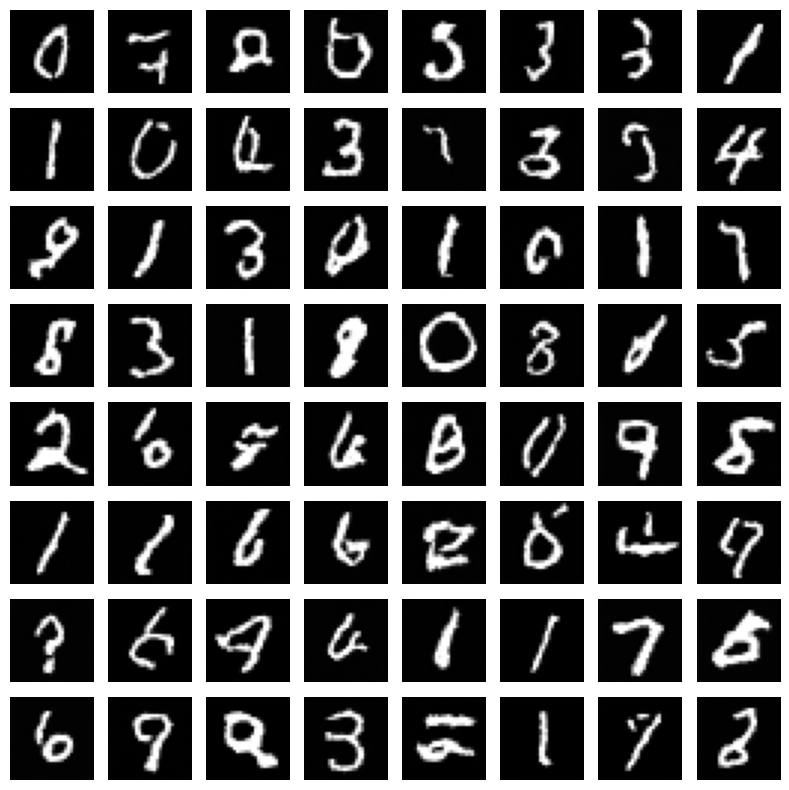

In [55]:
import os
import matplotlib.pyplot as plt
cfg = CONFIG()

# Generate
# generated_imgs = []
# for i in tqdm(range(cfg.num_img_to_generate)):
#     xt = generate(cfg)
#     xt = 255 * xt[0][0].numpy()
#     generated_imgs.append(xt.astype(np.uint8).flatten())

# # Save Generated Data CSV
# generated_df = pd.DataFrame(generated_imgs, columns=[f'pixel{i}' for i in range(784)])
# generated_df.to_csv(cfg.generated_csv_path, index=False)

os.makedirs("./generated_samples_kaggle", exist_ok=True)
generated_imgs = []
for i in range(64):  # Generate 16 samples
    with torch.no_grad():
        # Your generation code here
        xt = generate(cfg)  # This should return tensor in [0,1] range
        img = xt[0][0].cpu().numpy()  # Get first image
        
        # Save as PNG
        plt.imsave(f"./generated_samples_kaggle/sample_{i:03d}.png", img, cmap='gray')
        generated_imgs.append(img)


# Visualize in a grid (like they do)
fig, axes = plt.subplots(8, 8, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(generated_imgs[i], cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.savefig("./generated_samples_kaggle/grid.png", dpi=150, bbox_inches='tight')
plt.show()

In [56]:
def detailed_architecture_flow():
    print("KAGGLE UNET ARCHITECTURE - 28×28 MNIST")
    print("=" * 60)
    
    # Initial
    print("┌─────────────────────────────────────────────────────┐")
    print("│ INPUT:       28×28×1 (MNIST image)                 │")
    print("│ Conv1:       3×3 conv → 28×28×32                   │")
    print("└─────────────────────────────────────────────────────┘")
    print("                            ↓")
    
    # Down path
    print("┌─────────────────────────────────────────────────────┐")
    print("│ DOWN PATH (Encoder)                                │")
    print("├─────────────────────────────────────────────────────┤")
    print("│ DownC1: 28×28×32 → 14×14×64 (downsample 2×2)      │")
    print("│ DownC2: 14×14×64 → 7×7×128   (downsample 2×2)     │") 
    print("│ DownC3: 7×7×128 → 7×7×256    (no downsample)      │")
    print("└─────────────────────────────────────────────────────┘")
    print("                            ↓")
    
    # Bottleneck
    print("┌─────────────────────────────────────────────────────┐")
    print("│ BOTTLENECK (Middle)                               │")
    print("├─────────────────────────────────────────────────────┤")
    print("│ MidC1: 7×7×256 → 7×7×256 (process at low res)    │")
    print("│ MidC2: 7×7×256 → 7×7×128                         │")
    print("└─────────────────────────────────────────────────────┘")
    print("                            ↓")
    
    # Up path with skip connections
    print("┌─────────────────────────────────────────────────────┐")
    print("│ UP PATH (Decoder with Skip Connections)           │")
    print("├─────────────────────────────────────────────────────┤")
    print("│ UpC1: [7×7×128 + 7×7×256] → 14×14×128 (upsample) │")
    print("│        ↑ skip from DownC3                        │")
    print("│ UpC2: [14×14×128 + 14×14×64] → 28×28×64 (upsample)│")
    print("│        ↑ skip from DownC2                        │")
    print("│ UpC3: [28×28×64 + 28×28×32] → 28×28×16 (no upsample)")
    print("│        ↑ skip from Conv1                         │")
    print("└─────────────────────────────────────────────────────┘")
    print("                            ↓")
    
    # Final
    print("┌─────────────────────────────────────────────────────┐")
    print("│ OUTPUT:      28×28×1 (Predicted noise)            │")
    print("└─────────────────────────────────────────────────────┘")

# Visualize the flow
detailed_architecture_flow()

KAGGLE UNET ARCHITECTURE - 28×28 MNIST
┌─────────────────────────────────────────────────────┐
│ INPUT:       28×28×1 (MNIST image)                 │
│ Conv1:       3×3 conv → 28×28×32                   │
└─────────────────────────────────────────────────────┘
                            ↓
┌─────────────────────────────────────────────────────┐
│ DOWN PATH (Encoder)                                │
├─────────────────────────────────────────────────────┤
│ DownC1: 28×28×32 → 14×14×64 (downsample 2×2)      │
│ DownC2: 14×14×64 → 7×7×128   (downsample 2×2)     │
│ DownC3: 7×7×128 → 7×7×256    (no downsample)      │
└─────────────────────────────────────────────────────┘
                            ↓
┌─────────────────────────────────────────────────────┐
│ BOTTLENECK (Middle)                               │
├─────────────────────────────────────────────────────┤
│ MidC1: 7×7×256 → 7×7×256 (process at low res)    │
│ MidC2: 7×7×256 → 7×7×128                         │
└─────────────────────

In [57]:
def visualize_kaggle_unet_architecture():
    """Visualize how the Kaggle UNet processes images"""
    
    # Default parameters from your Kaggle code
    down_ch = [32, 64, 128, 256]
    mid_ch = [256, 256, 128] 
    up_ch = [256, 128, 64, 16]
    down_sample = [True, True, False]  # Only 3 down blocks for 4 down_ch values
    up_sample = [False, True, True]    # Reversed
    
    print("Kaggle UNet Architecture for MNIST (28×28):")
    print("=" * 50)
    
    # Input
    print("Input:     28×28×1")
    
    # Initial conv (no size change)
    print("Conv1:     28×28×32  (3×3 conv)")
    
    # Down path
    current_size = 28
    for i, (ch_in, ch_out, downsample) in enumerate(zip(down_ch[:-1], down_ch[1:], down_sample)):
        if downsample:
            current_size //= 2
            size_change = f"→ {current_size}×{current_size}"
        else:
            size_change = "(no downsample)"
        print(f"DownC{i+1}:   {current_size}×{current_size}×{ch_out} {size_change}")
    
    # Mid path (no size change)
    print(f"MidC:      {current_size}×{current_size}×{mid_ch[-1]} (bottleneck)")
    
    # Up path  
    for i, (ch_in, ch_out, upsample) in enumerate(zip(up_ch[:-1], up_ch[1:], up_sample)):
        if upsample:
            current_size *= 2
            size_change = f"→ {current_size}×{current_size}"
        else:
            size_change = "(no upsample)"
        print(f"UpC{i+1}:    {current_size}×{current_size}×{ch_out} {size_change}")
    
    # Output
    print(f"Output:    {current_size}×{current_size}×1")
    print("=" * 50)

# Run the visualization
visualize_kaggle_unet_architecture()

Kaggle UNet Architecture for MNIST (28×28):
Input:     28×28×1
Conv1:     28×28×32  (3×3 conv)
DownC1:   14×14×64 → 14×14
DownC2:   7×7×128 → 7×7
DownC3:   7×7×256 (no downsample)
MidC:      7×7×128 (bottleneck)
UpC1:    7×7×128 (no upsample)
UpC2:    14×14×64 → 14×14
UpC3:    28×28×16 → 28×28
Output:    28×28×1
